In [44]:
! pip install xgboost



In [45]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
import xgboost as xgb
import seaborn as sns


In [46]:
# load data
df = pd.read_excel('Synthetic_big.xlsx')
df.drop(['Unnamed: 0'], axis=1, inplace=True)
df.columns = df.columns.str.replace(r" \[.*?\]", "", regex=True)


In [47]:

# Display the first few rows of the DataFrame
df.head()

,Titer,avg .circumference,fiber length,fiber tenacity,W_q,W_Sm,expected concrete compression strength 95% rH,IFSS,Minibeam energy absorption (m.e.a.) 0-11,fiber failure mode in beam
0,500,3.150,40,450,0.0,0,25,6.834268,2695.440773,1
1,532,3.730,40,422,19.5,1276,25,5.818266,3076.427315,1
2,540,4.220,40,327,20.9,1230,25,5.425861,2297.532484,1
3,500,3.730,40,410,13.7,1243,25,5.811491,3229.171169,1
4,500,3.399,40,422,16.1,1324,25,6.649346,3517.499658,1


# logistic regression

In [48]:
X = df.iloc[:, :-1] 
y = df.iloc[:, -1] 

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [49]:
# fit
model = LogisticRegression()
model.fit(X_train, y_train)


/Users/miguelmeier/Desktop/UZH/semester4/.conda/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

Accuracy: 0.9930555555555556
Confusion Matrix:
 [[112   1]
 [  1 174]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       113
           1       0.99      0.99      0.99       175

    accuracy                           0.99       288
   macro avg       0.99      0.99      0.99       288
weighted avg       0.99      0.99      0.99       288



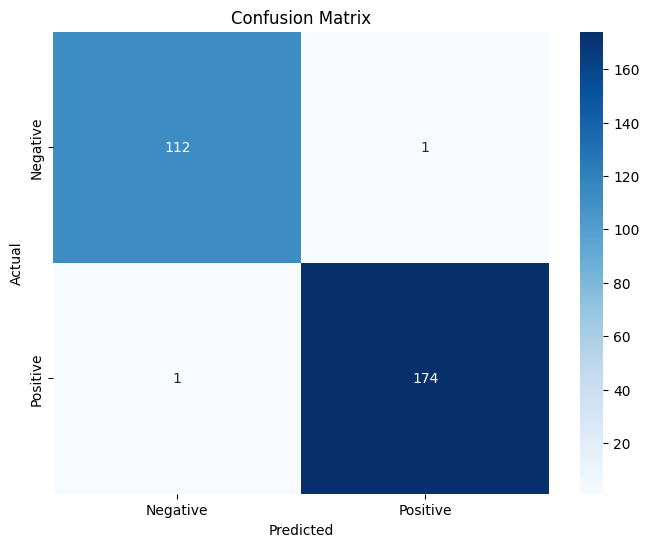

In [56]:
# evaluate
# Predicting the test set results
y_pred = model.predict(X_test)

# Evaluation metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()



                                         Feature  Coefficient
0                                          Titer    -0.021746
1                             avg .circumference     0.086083
2                                   fiber length     0.829890
3                                 fiber tenacity     0.007995
4                                            W_q    -0.003866
5                                           W_Sm     0.004889
6  expected concrete compression strength 95% rH     0.242835
7                                           IFSS     0.442525
8       Minibeam energy absorption (m.e.a.) 0-11    -0.006582


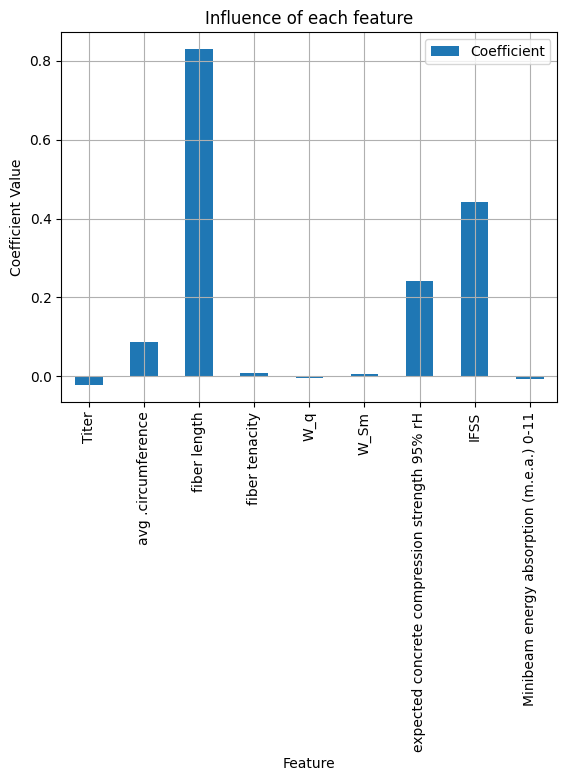

In [51]:
coefficients = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": model.coef_[0]
})

print(coefficients)

coefficients.set_index('Feature').plot.bar()
plt.title('Influence of each feature')
plt.ylabel('Coefficient Value')
plt.grid(True)
plt.show()


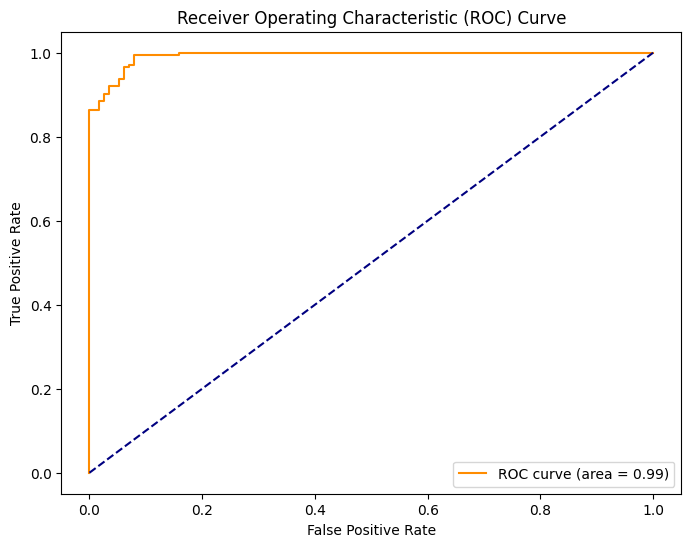

In [52]:
# ROC curve
y_probs = model.predict_proba(X_test)[:, 1]  
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

# Plot 
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (area = {roc_auc_score(y_test, y_probs):.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


this model performs quite well !

# XGBoost

In [53]:
# model
# Create XGBoost classifier
model = xgb.XGBClassifier(
    objective='binary:logistic',  # binary classification
    n_estimators=100,  # number of trees to build
    learning_rate=0.1,  # learning rate
    max_depth=3,  # depth of trees
    use_label_encoder=False,  # to avoid a deprecation warning
    eval_metric='logloss'  # loss function for binary classification
)

# Fit the model on the training data
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [54]:
# Making predictions
y_pred = model.predict(X_test)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)


Accuracy: 0.9930555555555556
Confusion Matrix:
 [[112   1]
 [  1 174]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       113
           1       0.99      0.99      0.99       175

    accuracy                           0.99       288
   macro avg       0.99      0.99      0.99       288
weighted avg       0.99      0.99      0.99       288



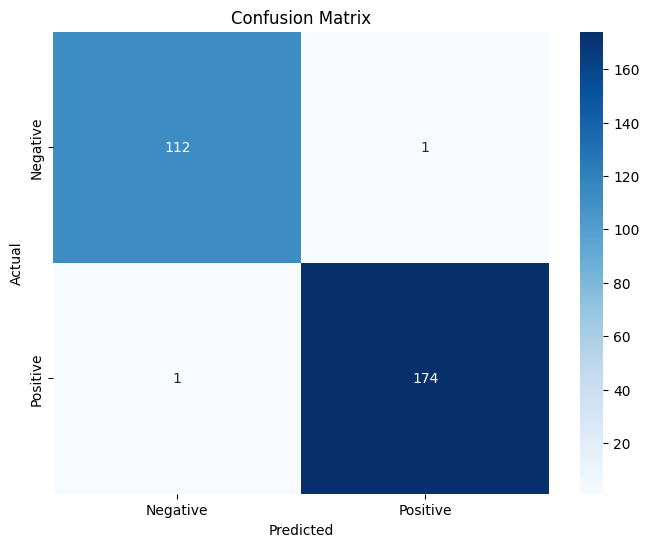

In [55]:


cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

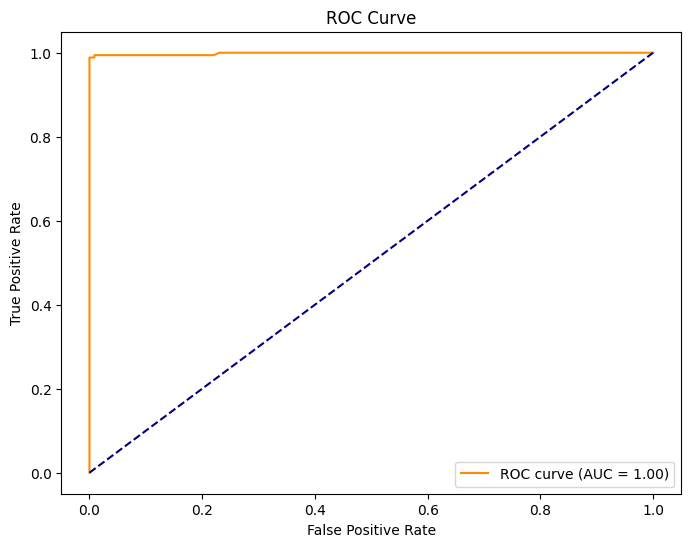

In [57]:
# ROC
y_probs = model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_probs)
auc_score = roc_auc_score(y_test, y_probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='navy')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

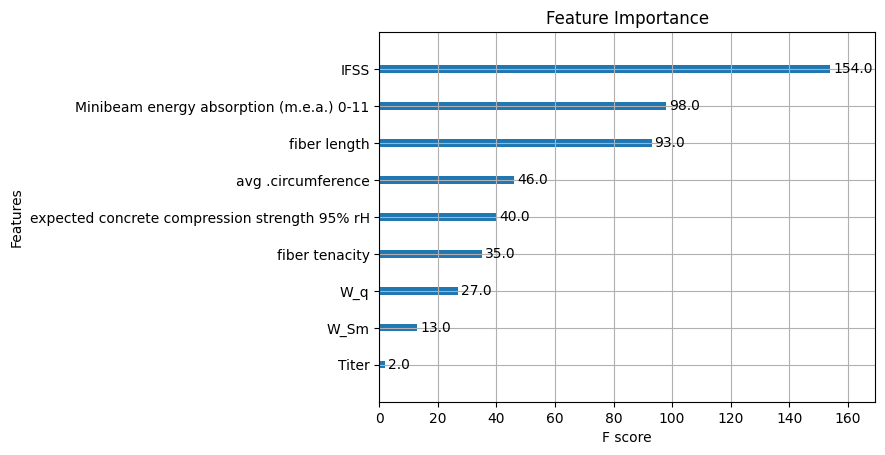

In [58]:
# feature importance
xgb.plot_importance(model, max_num_features=10)  # Plotting top 10 features
plt.title('Feature Importance')
plt.ylabel('Features')
plt.show()